# FanService-Meter: _How sexualized is your favorite manga?_

## Getting our datasets:

In [1]:
#use nhentai/random for hentai scraping
#use bato.to shonen for regular
import urllib
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import shutil
import cv2
import sys
import os.path

# some helpers
def spoofGetHtml(url):
    # Open the URL as Browser, not as python urllib
    page=urllib.request.Request(url,headers={'User-Agent': 'Mozilla/5.0'}) 
    infile=urllib.request.urlopen(page).read()
    return infile.decode('ISO-8859-1') # Read the content as string decoded with ISO-8859-1

def getImgLinksFromHTML(htmldata):
    soup = BeautifulSoup(htmldata, 'html.parser')
    images = soup.find_all('img')
    try:
        srcs = [item['src'] for item in images]
    except KeyError:
        return []
    i=0
    while i < len(srcs):
        #filter out gifs and svgs
        src = srcs[i]
        if not src.split(".")[-1] in ('jpg', 'jpeg', 'png'):
             while src in srcs: 
                    srcs.remove(src)
        i+=1
    return srcs
def getImgLinks(url):
    return getImgLinksFromHTML(spoofGetHtml(url))

def getRenderedImgLinks(url):
    fireFoxOptions = webdriver.FirefoxOptions()
    fireFoxOptions.set_headless()
    browser = webdriver.Firefox(options=fireFoxOptions)
    browser.get(url)
    html = browser.page_source
    return getImgLinksFromHTML(html)
    

def downloadImgs(urls, size,  folder):
    print('downloading urls:', urls)
    for url in urls:
        filename = folder+'/'+url.split('/')[-1]
        # in case images have generic names like image.jpg
        name, type_ = filename.split('.')
        type_ = type_.split('?')[0]
        numcopys = 0
        while os.path.exists(name+"({}).".format(numcopys)+type_):
            numcopys += 1
        
        filename= name+"({}).".format(numcopys)+type_
        r = requests.get(url, stream = True)
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True
        with open(filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        
        # set to grayscale and resize images so its uniform
        cvimg = cv2.imread(filename)
        cvimg = cv2.cvtColor(cv2.resize(cvimg, size), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(filename, cvimg)
    
#TODO: fuzz image datasets
NUM_IMAGES = 750
IMG_SIZE = (300, 300)

In [ ]:
# get our hentai dataset
img_count = 0
while img_count < NUM_IMAGES: #FIXME: the # of images it downloads is off but i dont rlly care
    images = getImgLinks('https://nhentai.net/random') #nhentai.net has a handy api
    img_count += len(images)
    downloadImgs(images, IMG_SIZE, 'res/hentai')

In [ ]:
import random
# get our shonen dataset
# our content provider bato.to doesn't have an api so we have to write a basic crawler
htmldata = spoofGetHtml('https://bato.to/browse?genres=shounen&sort=views_a.za') #top shonen manga by views
soup = BeautifulSoup(htmldata, 'html.parser')
serieslist = soup.find(id='series-list').find_all('a', class_ = 'item-cover')
serieslinks = [link['href'] for link in serieslist]
print('pulling images from following series', serieslinks)
MAX_PER_SERIES = 100 # to diversify set
total_img_count = 0
while total_img_count < NUM_IMAGES: #FIXME: the number of images it downloads is off but i dont rlly care
    htmldata = spoofGetHtml('https://bato.to' + random.choice(serieslinks))
    soup = BeautifulSoup(htmldata, 'html.parser')
    chapter_list = soup.find(class_='main').find_all('a', class_='visited chapt')
    series_img_count= 0
    while series_img_count < MAX_PER_SERIES:
        chapter_link = random.choice(chapter_list)['href']
        ch_img_links = getRenderedImgLinks('https://bato.to'+chapter_link)
        downloadImgs(ch_img_links, IMG_SIZE, 'res/manga')
        series_img_count += len(ch_img_links)
    total_img_count+=series_img_count
        

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    validation_split=0.2,
    subset="training",
    seed=23414,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    validation_split=0.2,
    subset="validation",
    seed=12547,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

Found 1127 files belonging to 2 classes.
Using 902 files for training.
Found 1127 files belonging to 2 classes.
Using 225 files for validation.


## As you can see, lael 0 is for hentai, and 1 is for shonen

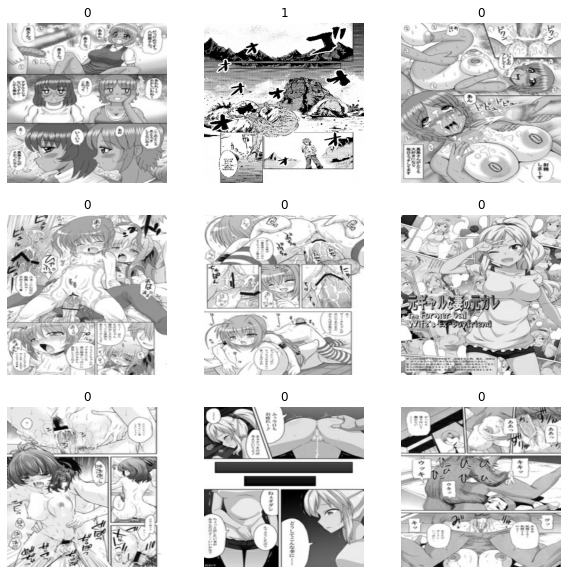

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Create the conv net model:

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs) # scale rgb to float
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    #HACK: ngl i dont rlly understand this part
    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        print(x.shape)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

(None, 150, 150, 64)
(None, 75, 75, 128)
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [6]:
model.summary()
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes
print('memory needed',get_model_memory_usage(batch_size, model),'gb')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

## Actually training the model:

In [10]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/5
29/29 [==============================] - 246s 8s/step - loss: 0.0000e+00 - accuracy: 0.9479 - val_loss: 0.0000e+00 - val_accuracy: 0.7200
Epoch 2/5


C:\Users\TheoA\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


29/29 [==============================] - 237s 8s/step - loss: 0.0000e+00 - accuracy: 0.9601 - val_loss: 0.0000e+00 - val_accuracy: 0.7200
Epoch 3/5
29/29 [==============================] - 225s 8s/step - loss: 0.0000e+00 - accuracy: 0.9490 - val_loss: 0.0000e+00 - val_accuracy: 0.7200
Epoch 4/5
29/29 [==============================] - 238s 8s/step - loss: 0.0000e+00 - accuracy: 0.9490 - val_loss: 0.0000e+00 - val_accuracy: 0.7200
Epoch 5/5
29/29 [==============================] - 248s 9s/step - loss: 0.0000e+00 - accuracy: 0.9180 - val_loss: 0.0000e+00 - val_accuracy: 0.7200


In [11]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Well, that didn't go well... why?
 * overfitting
 * poor loss function selection
 * maybe wrong optimizer?

## How can we improve it?
 * robust data augmentation
 * change loss function
 * more agressive dropout
 * give it more time on a GPU
 * isolate individual panels
 * use of L1 and L2 regularization (also known as "weight decay")

## But lets try a more fun approach
* _We can just scrap the whole current linear convnet architechture in favor of a GAN network_
### Architechture of a GAN-based network
* A GAN network consists of two nets, a Generator network, and an Adversarial Network
* They feed back on each other to improve each other
* The Adversarial network is an image catagorization net 
* The Generator network attempts to fool the adversarial network but finding ways to make images that produce false results
* Together they can form a very robust model capable of both generating and judging content